In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

torch.set_default_dtype(torch.float32)

Using cpu device


In [282]:
filename  = '../data/ising_data.npz'

f = np.load(filename, allow_pickle=True)
n_train = 20000
Xtr, Xtest = f["C"][:n_train], f["C"][n_train:]
print(Xtr.shape)
# Xtr, Xtest = torch.tensor(Xtr, dtype=torch.float32), torch.tensor(Xtest, dtype=torch.float32)
Xtr, Xtest = torch.Tensor(Xtr), torch.Tensor(Xtest) # using torch.Tensor instead of torch.tensor directly uses float32
Ttr, Ttest = f["T"][:n_train], f["T"][n_train:]
Ttr, Ttest = torch.Tensor(Ttr), torch.Tensor(Ttest)

(20000, 32, 32)


In [15]:
# class CustomDataset(Dataset):
#     def __init__(self, filename, cat, first, last):
#         self.file = np.load(filename, allow_pickle=True)
#         self.Xdata = torch.tensor(self.file[cat][first:last], dtype=torch.float32) 
#         self.Ydata = torch.tensor(self.file[cat][first:last], dtype=torch.float32) 

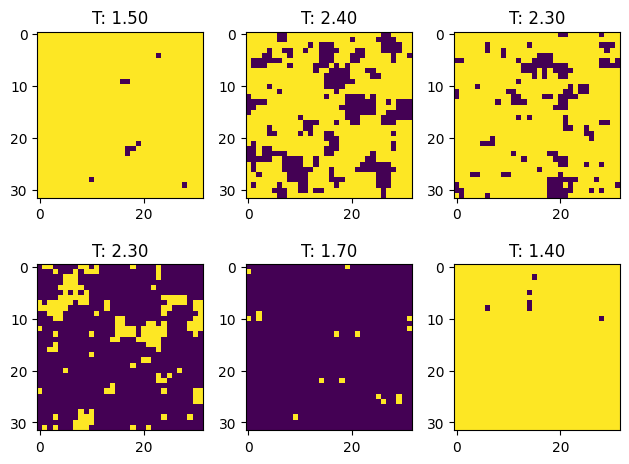

In [287]:
for i,j in enumerate(np.random.choice(n_train, 6)):
    plt.subplot(2,3,i+1)
    image = Xtr.detach().numpy()[j]
    plot = plt.imshow(image)
    plt.title(f"T: {Ttr[j]:.2f}")

plt.tight_layout()
plt.show()

In [146]:
Tc = 2.27
Ytr, Ytest = 1.0*F.one_hot(1*(Ttr > Tc)), 1.0*F.one_hot(1*(Ttest > Tc)) # meaning Unordered: [0, 1], Ordered [1, 0]

In [147]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(32*32, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return logits

In [288]:
torch.manual_seed(42)
model = NN()
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [290]:
b_size = 64

In [291]:
for i in range(1000):
    idxs = torch.randint(0, len(Xtr), (b_size,))
    logits = model(Xtr[idxs])
    loss = F.cross_entropy(logits, Ytr[idxs])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [358]:
probs = F.softmax(model(Xtest), dim=1)
Ypred = torch.multinomial(probs, 1).view(-1)
Ypred = 1.0*F.one_hot(Ypred)
print("Accuracy:", sum(1.0*torch.eq(Ypred, Ytest))[0].item()/len(Xtest))

Accuracy: 0.9725


In [357]:
print(sum(1.0*(torch.eq(Ytest, Ypred))))

tensor([5837., 5837.])


In [338]:
Ts = torch.arange(1.0, 3.5, 0.1)
ps = [probs[Ttest == Ts[i]] for i in range(len(Ts))] 
Ys = [torch.multinomial(p, 1).view(-1) for p in ps]
As = [sum(Ys[i] == 1*(Ts[i] > Tc).item()) for i in range(len(Ts))]

In [384]:
acc = 1.0*(Ypred == Ytest)[:, 0]

In [385]:
accs = [torch.mean(acc[Ttest == T]) for T in Ts]

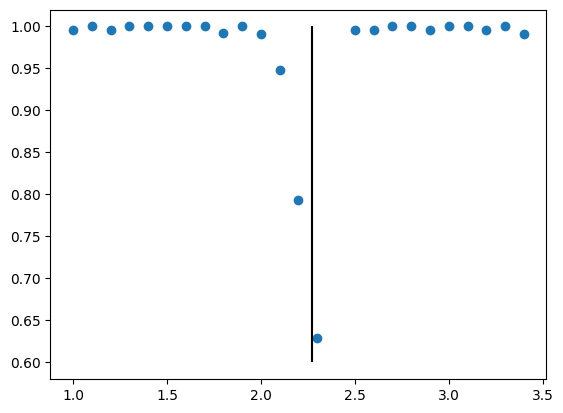

In [389]:
plt.scatter(Ts, accs)
plt.vlines(Tc, 0.6, 1.0, color='black')